# Titanic survival classification

In [27]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, recall_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from scipy import interp

## Loading data & Preliminary analysis

### Handling irrelevant variables and missing values

In [28]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
datasets = [df_train,df_test]
df0 = df_train

In [29]:
for df in datasets :
    print(df.count(),'\n') #count the number on non NaN rows

#There are missing values in the Age, Cabin, Fare and Embarked columns

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64 

PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin           91
Embarked       418
dtype: int64 



The Cabin variable has too many missing values, we will drop it.

In [30]:
for df in datasets :
    display(df.describe(include='all'))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Fortune, Miss. Mabel Helen",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Dika, Mr. Mirko",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


Not all variables are relevant to predict survival so we delete the obviously useless variables, such as 'PassengerId', 'Name', 'Cabin' and 'Ticket number'.
We use the age and fare mean and the port of embarkation mode to replace the missing values.

In [31]:
for df in datasets :
    dropCol = ['PassengerId','Name','Ticket', 'Cabin']
    df.drop(dropCol, axis=1, inplace = True)
    
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)
    df['Fare'].fillna(df['Fare'].mean(), inplace = True)

    print(df.count()) #no more missing values
    display(df.head()) #dataset without irrelevant variables

Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch       891
Fare        891
Embarked    891
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Pclass      418
Sex         418
Age         418
SibSp       418
Parch       418
Fare        418
Embarked    418
dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


### Standard Scaling

We want the non categorical variables to have a standardized range so that one doesn't have more weight when building the ML model.

In [32]:
scaler = StandardScaler()
for df in datasets :
    df[['Age','SibSp', 'Parch', 'Fare']] = scaler.fit_transform(df[['Age','SibSp', 'Parch', 'Fare']])
    display(df)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,-0.592481,0.432793,-0.473674,-0.502445,S
1,1,1,female,0.638789,0.432793,-0.473674,0.786845,C
2,1,3,female,-0.284663,-0.474545,-0.473674,-0.488854,S
3,1,1,female,0.407926,0.432793,-0.473674,0.420730,S
4,0,3,male,0.407926,-0.474545,-0.473674,-0.486337,S
...,...,...,...,...,...,...,...,...
886,0,2,male,-0.207709,-0.474545,-0.473674,-0.386671,S
887,1,1,female,-0.823344,-0.474545,-0.473674,-0.044381,S
888,0,3,female,0.000000,0.432793,2.008933,-0.176263,S
889,1,1,male,-0.284663,-0.474545,-0.473674,-0.044381,C


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,0.334993,-0.499470,-0.400248,-0.498407,Q
1,3,female,1.325530,0.616992,-0.400248,-0.513274,S
2,2,male,2.514175,-0.499470,-0.400248,-0.465088,Q
3,3,male,-0.259330,-0.499470,-0.400248,-0.483466,S
4,3,female,-0.655545,0.616992,0.619896,-0.418471,S
...,...,...,...,...,...,...,...
413,3,male,0.000000,-0.499470,-0.400248,-0.494448,S
414,1,female,0.691586,-0.499470,-0.400248,1.313753,C
415,3,male,0.651965,-0.499470,-0.400248,-0.508792,S
416,3,male,0.000000,-0.499470,-0.400248,-0.494448,S


### OneHot Encoding

OneHot encoding of the categorical variables 'Sex' and 'Embarked'.
The categorical variable Pclass is already encoded.

In [33]:
i=0
for df in datasets :
    dfDummiesSex = pd.get_dummies(df['Sex'], prefix = 'Sex')
    dfDummiesPort = pd.get_dummies(df['Embarked'], prefix = 'Port')
    dfDummies = pd.concat([dfDummiesSex, dfDummiesPort], axis=1)

    df = pd.concat([df, dfDummies],axis=1)
    df.drop(['Sex','Embarked'], axis=1, inplace = True)
    display(df.head())
    datasets[i] = df
    i+=1

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
0,0,3,-0.592481,0.432793,-0.473674,-0.502445,0,1,0,0,1
1,1,1,0.638789,0.432793,-0.473674,0.786845,1,0,1,0,0
2,1,3,-0.284663,-0.474545,-0.473674,-0.488854,1,0,0,0,1
3,1,1,0.407926,0.432793,-0.473674,0.420730,1,0,0,0,1
4,0,3,0.407926,-0.474545,-0.473674,-0.486337,0,1,0,0,1


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
0,3,0.334993,-0.499470,-0.400248,-0.498407,0,1,0,1,0
1,3,1.325530,0.616992,-0.400248,-0.513274,1,0,0,0,1
2,2,2.514175,-0.499470,-0.400248,-0.465088,0,1,0,1,0
3,3,-0.259330,-0.499470,-0.400248,-0.483466,0,1,0,0,1
4,3,-0.655545,0.616992,0.619896,-0.418471,1,0,0,0,1


## Exploratory and Descriptive Analysis

In [34]:
df_train = datasets[0]
df_test = datasets[1]

In [35]:
#Correlation Table
df_train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
Survived,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307,0.543351,-0.543351,0.168240,0.003650,-0.149683
Pclass,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.243292,0.221009,0.074053
Age,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566,-0.084153,0.084153,0.032024,-0.013855,-0.019336
SibSp,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.059528,-0.026354,0.068734
Parch,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225,0.245489,-0.245489,-0.011069,-0.081228,0.060814
Fare,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000,0.182333,-0.182333,0.269335,-0.117216,-0.162184
Sex_female,0.543351,-0.131900,-0.084153,0.114631,0.245489,0.182333,1.000000,-1.000000,0.082853,0.074115,-0.119224
Sex_male,-0.543351,0.131900,0.084153,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.082853,-0.074115,0.119224
Port_C,0.168240,-0.243292,0.032024,-0.059528,-0.011069,0.269335,0.082853,-0.082853,1.000000,-0.148258,-0.782742
Port_Q,0.003650,0.221009,-0.013855,-0.026354,-0.081228,-0.117216,0.074115,-0.074115,-0.148258,1.000000,-0.499421


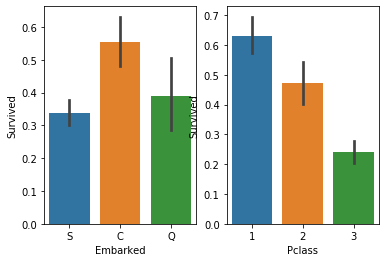

In [36]:
#Survival according to Class and Port of Embarkation
fig, axis = plt.subplots(1, 2)
sns.barplot('Embarked','Survived', data=df0, ax = axis[0])
sns.barplot('Pclass','Survived', data=df_train, ax = axis[1])

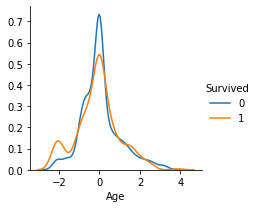

In [37]:
#Survival according to Age
ageplot = sns.FacetGrid(df_train, hue = 'Survived' )
ageplot.map(sns.kdeplot, 'Age')
ageplot.add_legend()

In [38]:
#Survival according to sex
df_train.iloc[:,[0,6,7]].groupby(['Survived']).mean()

,Sex_female,Sex_male
Survived,,
0,0.147541,0.852459
1,0.681287,0.318713


The lower the class, the lower the chance of survival, the lower the age and the lower the fare.

The higher the fare, the higher the chance of survival and the higher the number of family members.

The higher the age, the higher the number of family members.

Passengers in their mid to late 20s were more likely to survive.

Women were more likely to survive. Men were less likely to survive.

# Modeling

Now that we've gone through the descriptive analysis of the data, let's find the best algorithm to model survival.

In [39]:
data_x = df_train.iloc[:,1:]
data_y = df_train.iloc[:,0]
print(data_x.shape)
print(data_y.shape)

(891, 10)
(891,)


In [40]:
#Data splitting into training and test sets. We make sure that both sets have about the same variable distribution.
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=555)
print(X_train.shape)
print(X_test.shape)

display(y_train.describe())
display(y_test.describe())
display(X_train.describe())
display(X_test.describe())

(668, 10)
(223, 10)


count    668.000000
mean       0.398204
std        0.489895
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

count    223.000000
mean       0.340807
std        0.475047
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,2.267964,0.019889,0.009006,0.015043,0.033705,0.357784,0.642216,0.187126,0.085329,0.727545
std,0.854510,1.019933,0.997581,1.000660,1.064292,0.479707,0.479707,0.390305,0.279581,0.445556
min,1.000000,-2.253155,-0.474545,-0.473674,-0.648422,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,-0.515526,-0.474545,-0.473674,-0.488854,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,-0.474545,-0.473674,-0.331384,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,0.484880,0.432793,-0.473674,-0.016444,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,3.870872,6.784163,6.974147,9.667167,1.000000,1.000000,1.000000,1.000000,1.000000


,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Port_C,Port_Q,Port_S
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,2.430493,-0.059576,-0.026979,-0.045062,-0.100965,0.336323,0.663677,0.192825,0.089686,0.717489
std,0.767213,0.939830,1.011213,1.001161,0.772400,0.473514,0.473514,0.395404,0.286374,0.451234
min,1.000000,-2.208522,-0.474545,-0.473674,-0.648422,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,-0.669435,-0.474545,-0.473674,-0.489442,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,-0.474545,-0.473674,-0.401268,0.000000,1.000000,0.000000,0.000000,1.000000
75%,3.000000,0.254017,0.432793,-0.473674,-0.109315,1.000000,1.000000,0.000000,0.000000,1.000000
max,3.000000,3.178283,6.784163,5.732844,4.634417,1.000000,1.000000,1.000000,1.000000,1.000000


We train the different models with cross-validation and then test their prediction accuracy on the test set

In [41]:
modelnames = [
    "Logistic Regression",
    "Linear SVC",
    "SVC",
    "Ridge Classifier",
    "Decision Tree Classifier",
    "Gradient Boosting Classifier",
    "K Neighbors Classifier",
    "Random Forest Classifier"
]

models = [
    LogisticRegression(solver='lbfgs'),
    LinearSVC(max_iter=10000),
    SVC(probability=True, gamma = 'auto'),
    RidgeClassifier(),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    RandomForestClassifier(n_estimators=100)
]

fitted_models = dict()

#comparison table of models performance
table_cols = ['Model', 'Training mean accuracy', 'Validation mean accuracy', 'Testing accuracy']
df_table = pd.DataFrame(columns = table_cols)

#predictions table of the test set
pred_table = pd.DataFrame(y_test, columns = ['Survived'])
pred_table = pred_table.reset_index(drop=True)

i = 0
for model in models:
    df_table.loc[i, 'Model'] = modelnames[i]
    print(modelnames[i])
    
    #Cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    
    #Model Fitting
    model.fit(X_train, y_train)
    fitted_models[modelnames[i]] = model
    
    #Predictions on the test set
    y_pred = model.predict(X_test)
    
    #Populating the tables
    df_table.loc[i, 'Training mean accuracy'] = cv_results['train_score'].mean()
    df_table.loc[i, 'Validation mean accuracy'] = cv_results['test_score'].mean()   
    df_table.loc[i, 'Testing accuracy'] = accuracy_score(y_test, y_pred)
    
    pred_table = pd.concat([pred_table, pd.DataFrame(y_pred, columns = [modelnames[i]])], axis=1)
    
    i+=1

df_table.sort_values(by = ['Testing accuracy', 'Validation mean accuracy'], ascending = False, inplace = True)
display(df_table)
display(pred_table.tail())

Logistic Regression
Linear SVC
SVC
Ridge Classifier
Decision Tree Classifier
Gradient Boosting Classifier
K Neighbors Classifier
Random Forest Classifier


,Model,Training mean accuracy,Validation mean accuracy,Testing accuracy
2,SVC,0.816198,0.80971,0.887892
6,K Neighbors Classifier,0.843481,0.77999,0.860987
1,Linear SVC,0.784262,0.770989,0.847534
3,Ridge Classifier,0.783432,0.769451,0.847534
5,Gradient Boosting Classifier,0.902863,0.821764,0.838565
0,Logistic Regression,0.789255,0.772504,0.834081
7,Random Forest Classifier,0.985528,0.791798,0.811659
4,Decision Tree Classifier,0.985694,0.766082,0.798206


,Survived,Logistic Regression,Linear SVC,SVC,Ridge Classifier,Decision Tree Classifier,Gradient Boosting Classifier,K Neighbors Classifier,Random Forest Classifier
218,1,1,1,1,1,1,1,1,1
219,1,1,1,1,1,0,1,1,0
220,1,0,0,0,0,1,0,0,1
221,0,0,0,0,0,0,0,0,0
222,0,0,0,0,0,0,0,0,0


#### ROC curve visualization

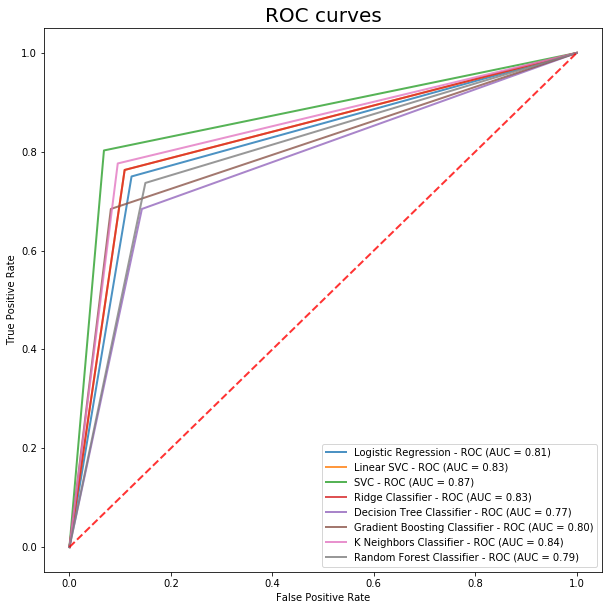

In [42]:
y_true = pred_table['Survived']
plt.figure(figsize=(10,10))

for i in range(1,len(pred_table.columns)):
    modelName = pred_table.columns[i]
    model = models[i-1]
    
    y_pred = pred_table[modelName]

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr,
             label=r'%s - ROC (AUC = %0.2f)' % (modelName,roc_auc),
             lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves', fontsize=20)
plt.legend(loc="lower right")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)   
#plt.savefig('ROC_curves', fontsize=20)
plt.show()

The SVC model has the ROC curve with the biggest AUC (~87% prediction accuracy). Therefore, it makes the most accurate predictions.

In our case, since the chance of survival is so low, we mostly want to minimize False Negatives. We don't want to predict a death when the passenger actually survived. With this logic, we pay close attention to the Recall (TP/TP+FN). 

In [43]:
recall_table = pd.DataFrame([recall_score(pred_table['Survived'],pred_table.iloc[:,1])], columns = [modelnames[0]])

for i in range(2,9):
    recall_table.loc[0, modelnames[i-1]] = recall_score(pred_table['Survived'],pred_table.iloc[:,i])
recall_table = recall_table.rename(index={0: "Recall"})
display(recall_table)

,Logistic Regression,Linear SVC,SVC,Ridge Classifier,Decision Tree Classifier,Gradient Boosting Classifier,K Neighbors Classifier,Random Forest Classifier
Recall,0.75,0.763158,0.802632,0.763158,0.684211,0.684211,0.776316,0.736842


In [44]:
print("Confusion Matrix:")
print(confusion_matrix(pred_table['Survived'],pred_table['SVC']))

print("\nClassification Report:")
print(classification_report(pred_table['Survived'],pred_table['SVC']))

Confusion Matrix:
[[137  10]
 [ 15  61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       147
           1       0.86      0.80      0.83        76

    accuracy                           0.89       223
   macro avg       0.88      0.87      0.87       223
weighted avg       0.89      0.89      0.89       223



The Support Vector Machine Classification appears to make the most accurate predictions (highest recall and biggest AUC). We avoided overfitting and reached a very performant model without any tuning. So let's see if Hyperparameter Optimization would improve the SVC modelization even more before making the final predictions on the test data.

(I initially also wanted to apply Feature Selection to improve the model but RFECV only works with linear models and 'LinearSVC' has worse performance than 'SVC', so I drop the Feature Selection step)

# Hyperparameter Optimization

We want to identify the hyperparameters that optimize the accuracy of the SVC model we selected earlier.

For details on the roles of C and gamma, see : https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine

In [45]:
# set up params
param_grid = {'C': [0.001,0.01,0.1,1,10,100,1000],
              'gamma' : ['auto','scale']
             }

grid = GridSearchCV(SVC(probability=True), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
print('Best Hyperparameters for SVC modeling : ',grid.best_params_)

Best Hyperparameters for SVC modeling :  {'C': 10, 'gamma': 'auto'}


In [46]:
#table of model performance
table_cols = ['Model', 'Validation mean accuracy', 'Testing accuracy']
df_gridtable = pd.DataFrame(columns = table_cols)

#prediction table on the test set
pred_gridtable = pd.DataFrame(y_test, columns = ['Survived'])
pred_gridtable = pred_gridtable.reset_index(drop=True)
df_gridtable.loc[0, 'Model'] = "SVC"

#Prediction on the test set
y_pred = grid.predict(X_test)

#Populating the tables
df_gridtable.loc[0, 'Validation mean accuracy'] = grid.best_score_  
df_gridtable.loc[0, 'Testing accuracy'] = accuracy_score(y_test, y_pred)

pred_gridtable = pd.concat([pred_gridtable, pd.DataFrame(y_pred, columns = ["SVC"])], axis=1)

df_gridtable.sort_values(by = ['Testing accuracy', 'Validation mean accuracy'], ascending = False, inplace = True)
print('Performance WITH Hyperparameter Optimization :')
display(df_gridtable)

#performance of the original SVC model
print('Performance WITHOUT Hyperparameter Optimization :')
display(df_table.iloc[[0],:])

Performance WITH Hyperparameter Optimization :


,Model,Validation mean accuracy,Testing accuracy
0,SVC,0.814371,0.852018


Performance WITHOUT Hyperparameter Optimization :


,Model,Training mean accuracy,Validation mean accuracy,Testing accuracy
2,SVC,0.816198,0.80971,0.887892


The hyperparameter optimization doesn't significantly improve the model accuracy compared to the 'default' SVC model. It even made it worse (85 < 88), probably because the cross-validation scheme is different in the GridSearchCV. Therefore, we will use the 'default' SVC model to predict the passengers' survival.

# Survival Predictions

In [47]:
#Survival predictions for the passengers from the test.csv file
data_pred = fitted_models['SVC'].predict(df_test)

#retrieve the passengers' ID
passID = pd.read_csv('test.csv').iloc[:,[0]]

#Submission format of the prediction
pred_survival = pd.concat([passID, pd.DataFrame(data_pred,columns = ["Survived"])], axis=1)
display(pred_survival)

#Output CSV file
pred_survival.to_csv("PierreMkt_TitanicSubmission.csv",index=False)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


After submitting my predictions to Kaggle I got a 0.78947 accuracy score. Not too bad.

I think the Feature Engineering and Feature Selection parts are critical in building a very performant model. Having glanced over a few solutions afterwards, I realize that I could/should have worked more on feature extraction (retrieving titles from Names, family size, using bins of Age and/or fare price etc...). Build a model with predictors that make the most sense is indeed key.